In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import feature_engineering_functions as fef
import machine_learning_functions as mlf

# Load the dataset
# Load the .pkl file
file_path = 'smart_app_data.pkl'
historical_data = pd.read_pickle(file_path)

In [2]:
kpis = historical_data['kpi'].unique()
print("------------ kpis are ----------------")
print(kpis)

machines = historical_data['name'].unique()
print("------------ machines are ----------------")
print(machines)

'''operations = historical_data['operation'].unique()
print("------------ operations are ----------------")
print(operations)'''


------------ kpis are ----------------
['working_time' 'idle_time' 'offline_time' 'consumption' 'power'
 'consumption_working' 'consumption_idle' 'cost' 'cost_working'
 'cost_idle' 'cycles' 'good_cycles' 'bad_cycles' 'average_cycle_time']
------------ machines are ----------------
['Large Capacity Cutting Machine 1' 'Riveting Machine'
 'Medium Capacity Cutting Machine 1' 'Laser Cutter'
 'Large Capacity Cutting Machine 2' 'Medium Capacity Cutting Machine 2'
 'Testing Machine 1' 'Testing Machine 2' 'Low Capacity Cutting Machine 1'
 'Medium Capacity Cutting Machine 3' 'Assembly Machine 1'
 'Laser Welding Machine 1' 'Assembly Machine 2' 'Assembly Machine 3'
 'Laser Welding Machine 2' 'Testing Machine 3']


'operations = historical_data[\'operation\'].unique()\nprint("------------ operations are ----------------")\nprint(operations)'

In [3]:
def extract_features(kpi_name, machine_name, operation_name, data):

  # function that is able to extract time series filtering for:
  # kpi_vame = name of the kpi
  # kpi_value = which should be chose in the list ['sum', 'avg','min', 'max']
  # machine_name = name of the machine
  # data = name of the dataframe from which data are provided

  filtered_data = data[(data["name"] == machine_name) &
                    (data["kpi"] == kpi_name)]
  #later replace by
  #filtered_data = data[(data["name"] == machine_name) &
  # (data["kpi"] == kpi_name)] & (data["operation"] == operation_name)]
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])
  filtered_data = filtered_data.sort_values(by='time')

  return filtered_data

processing_config = {
    'make_stationary': True,  # Default: False
    'detrend': True,          # Default: False
    'deseasonalize': True,    # Default: False
    'get_residuals': True,    # Default: False
    'scaler': True             # Default: True
}


In [4]:
# The input dataframe corresponds to a filtrate version of the dataset for a given machine, kpi and operation,
# so it contains 9 columns and the amount of entries correspondent to the selected time range.

def feature_engineering_pipeline(dataframe, kwargs):
    features = ['sum', 'avg','min', 'max', 'var']
    for feature_name in features:
        # Check if the column exists in the DataFrame
        if feature_name in dataframe.columns:
            print("-------------------- Results for " + str(feature_name))
            feature = dataframe[feature_name]
            if feature.empty or feature.isna().all() or feature.isnull().all():
                print("Feature is empty (no data).")
            else:
                ## Check stationarity 
                # (output is False if not stationary, True if it is, None if test couldn't be applied)
                is_stationary = fef.adf_test(feature.dropna()) 
                print('Output is stationary? ' + str(is_stationary))
            
                ## Check seasonality
                # (output: period of the seasonality None if no seasonalaty was detected.
                seasonality_period = fef.detect_seasonality_acf(feature)
                print('Seasonality period is? ' + str(seasonality_period))
            
                #further check in the case the seasonality pattern is complex and cannot be detected
                if seasonality_period == None:
                    # (output: period of the seasonality None if no seasonalaty was detected.
                    seasonality_period = fef.detect_seasonality_fft(feature)
                    print('Recomputed seasonality period is? ' + str(seasonality_period))
            
                # (output: the decomposed time series in a list, of form [trend, seasonal, residual],
                # None if it isn't sufficient data or if some error occurs.
                decompositions = fef.seasonal_additive_decomposition(feature, seasonality_period) 

                #Make data stationary / Detrend / Deseasonalize (if needed)
            
                make_stationary = kwargs.get('make_stationary', False)  # Set default to False if not provided
                detrend = kwargs.get('detrend', False) # Set default to False if not provided
                deseasonalize = kwargs.get('deseasonalize', False) # Set default to False if not provided
                get_residuals = kwargs.get('get_residuals', False) # Set default to False if not provided
                scaler = kwargs.get('scaler', False)  # Set default to False if not provided
                
                if make_stationary and (not is_stationary):
                    if decompositions != None:
                        feature = fef.make_stationary_decomp(feature, decompositions)
                        is_stationary = fef.adf_test(feature.dropna())
                        print('Is stationary after trying to make it stationary? ' + str(is_stationary))
                        if not is_stationary:
                            feature = fef.make_stationary_diff(feature, seasonality_period=[7]) #default weekly
                            is_stationary = fef.adf_test(feature.dropna())
                            print('Is stationary after re-trying to make it stationary? ' + str(is_stationary))
                    else:
                        feature = fef.make_stationary_diff(feature, seasonality_period=[7]) #default weekly
                        is_stationary = fef.adf_test(feature.dropna())
                        print('Is stationary after trying to make it stationary? ' + str(is_stationary))
            
                if detrend:
                    if decompositions != None:
                        feature = fef.rest_trend(feature, decompositions)
                    else:
                        feature = fef.make_stationary_diff(feature)
                
                if deseasonalize:
                    if decompositions != None:
                        feature = fef.rest_seasonality(feature, decompositions)
                    else:
                        feature = fef.make_stationary_diff(feature, seasonality_period=[7]) #default weekly
            
                if get_residuals:
                    if decompositions != None:
                        feature = fef.get_residuals(feature, decompositions)
                    else:
                        feature = fef.make_stationary_diff(feature)
                        feature = fef.make_stationary_diff(feature, seasonality_period=[7]) #default weekly
                
                if scaler:
                    # Apply standardization (z-score scaling)
                    feature = (feature - np.mean(feature)) / np.std(feature)
            
            dataframe[feature_name] = feature

    return dataframe

Change detected at index 179
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? 2


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

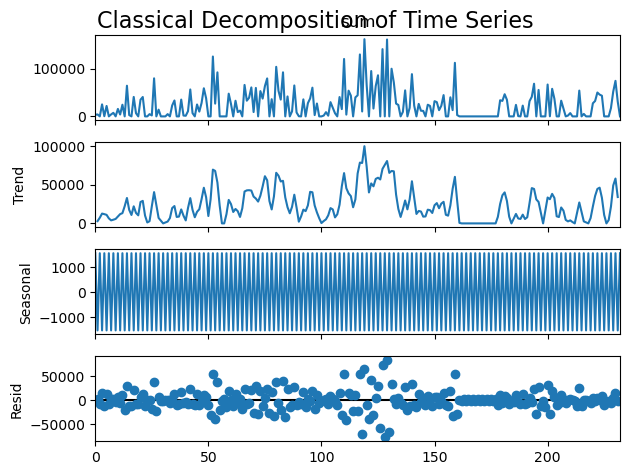

-------------------- Results for avg
Output is stationary? True
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

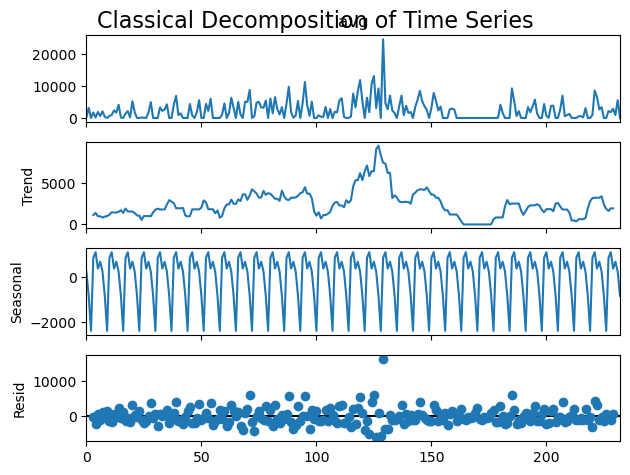

-------------------- Results for min
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
-------------------- Results for max
Output is stationary? True
Seasonality period is? 2


<Figure size 1000x800 with 0 Axes>

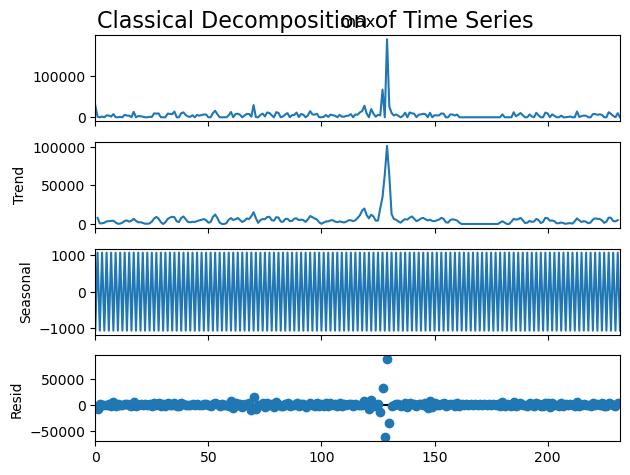

C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

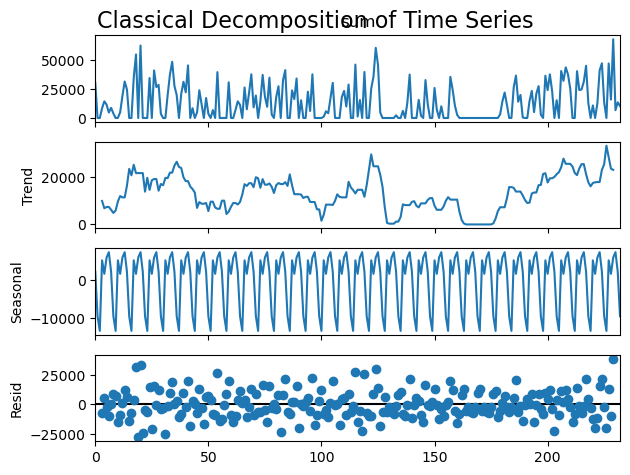

-------------------- Results for avg
Output is stationary? True
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

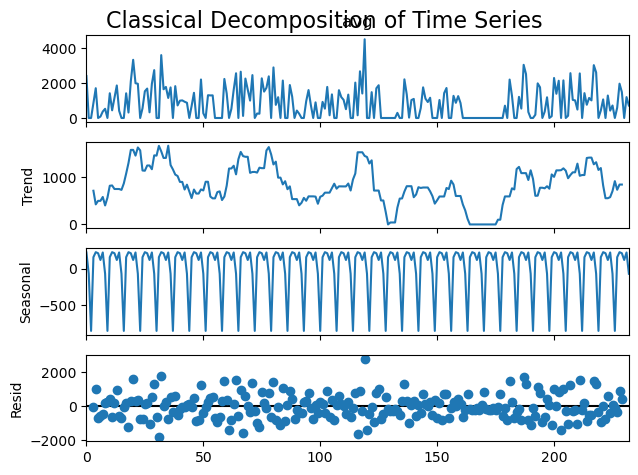

-------------------- Results for min
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 3


<Figure size 1000x800 with 0 Axes>

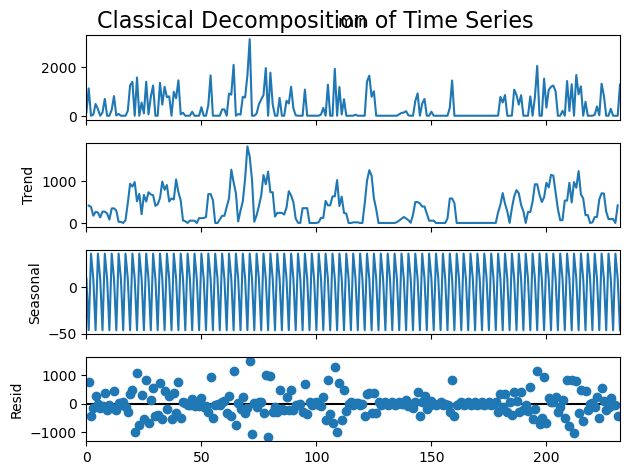

-------------------- Results for max
Output is stationary? True
Seasonality period is? 21


<Figure size 1000x800 with 0 Axes>

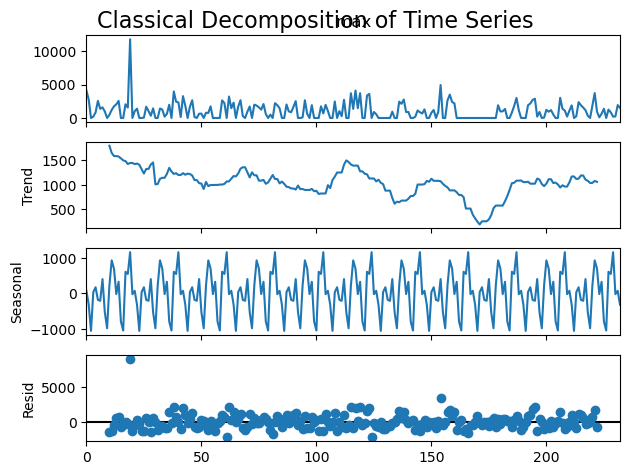

_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? 7


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

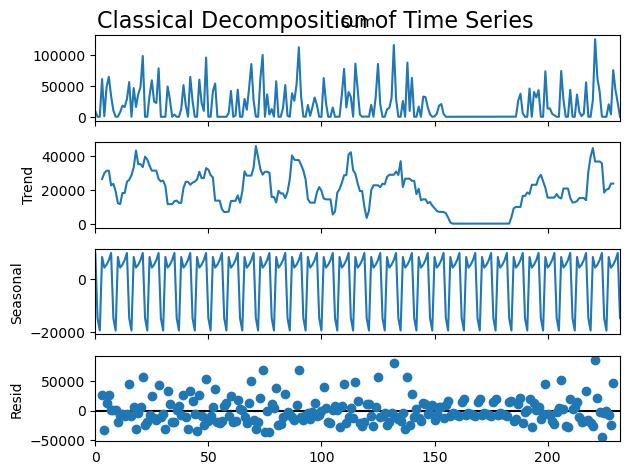

-------------------- Results for avg
Output is stationary? True
Seasonality period is? 6


<Figure size 1000x800 with 0 Axes>

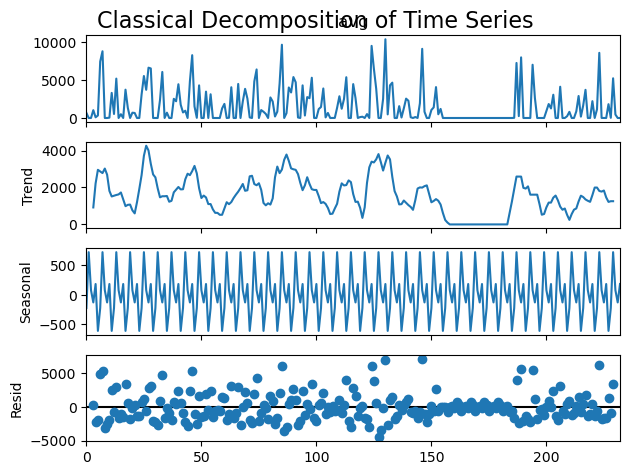

-------------------- Results for min
Output is stationary? True
Seasonality period is? 47


<Figure size 1000x800 with 0 Axes>

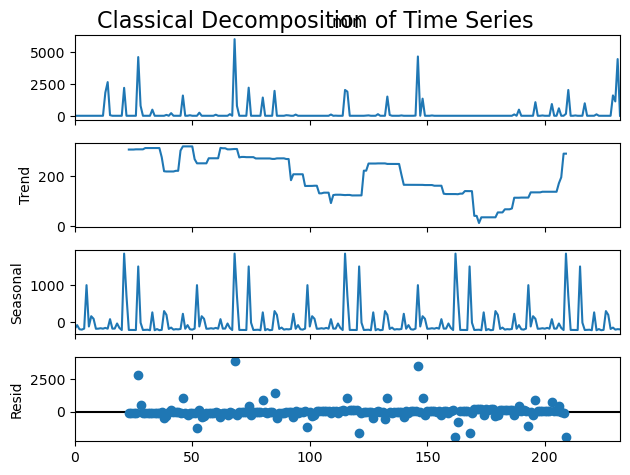

-------------------- Results for max
Output is stationary? True
Seasonality period is? 21


<Figure size 1000x800 with 0 Axes>

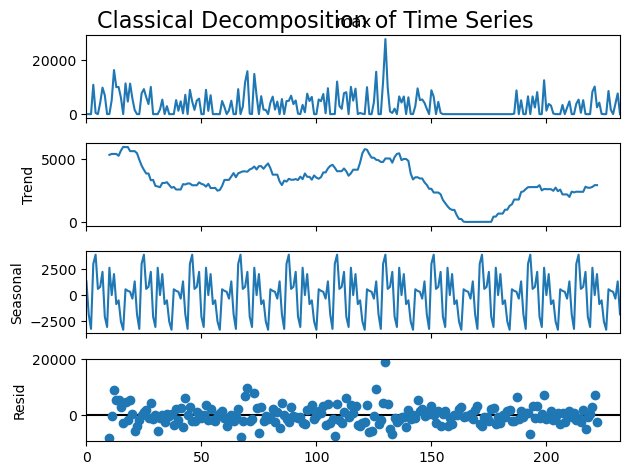

_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? 42


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

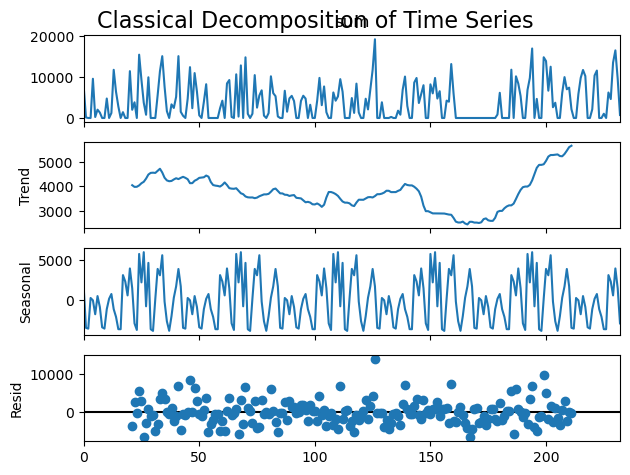

-------------------- Results for avg
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

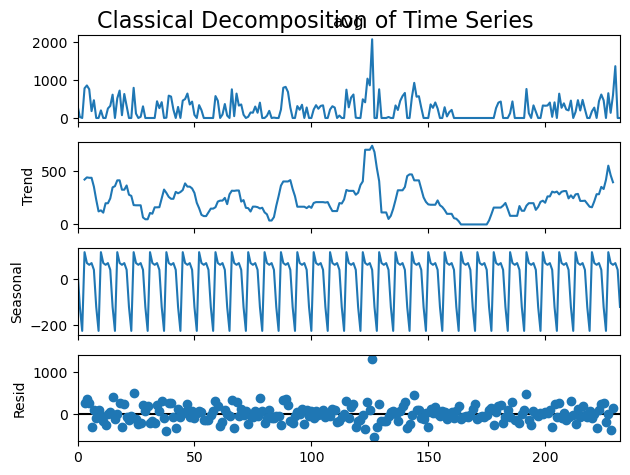

-------------------- Results for min
Output is stationary? True
Seasonality period is? 45


<Figure size 1000x800 with 0 Axes>

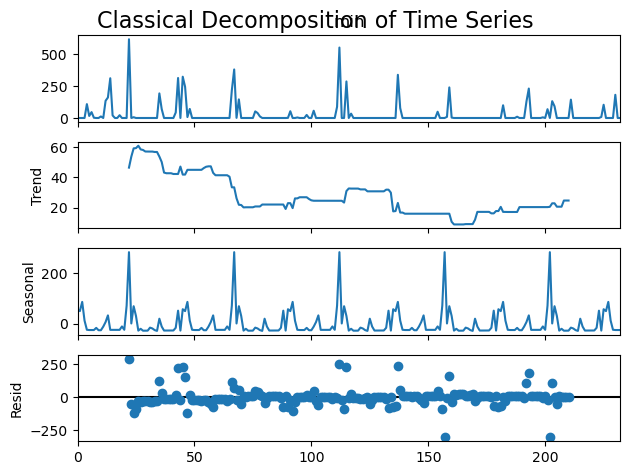

-------------------- Results for max
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Change detected at index 149
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 7


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

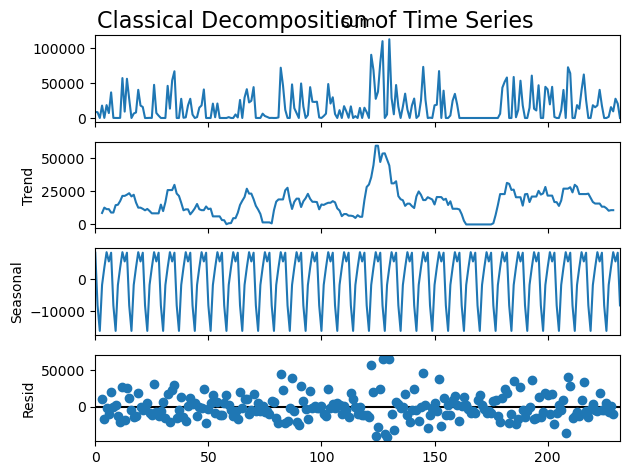

-------------------- Results for avg
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

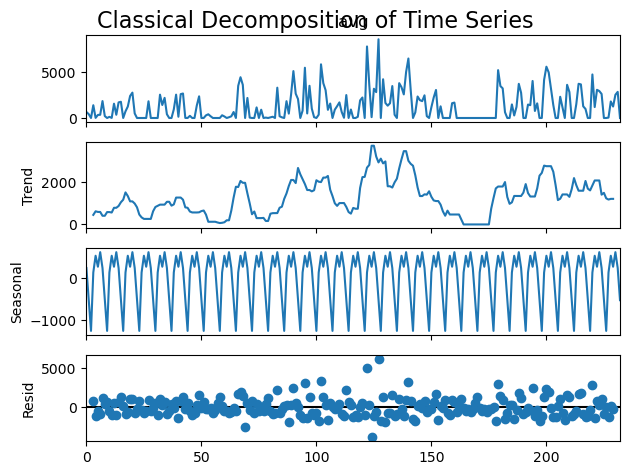

-------------------- Results for min
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

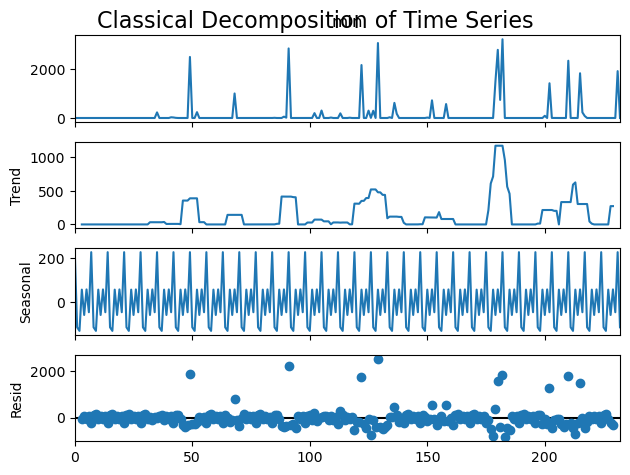

-------------------- Results for max
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 116


<Figure size 1000x800 with 0 Axes>

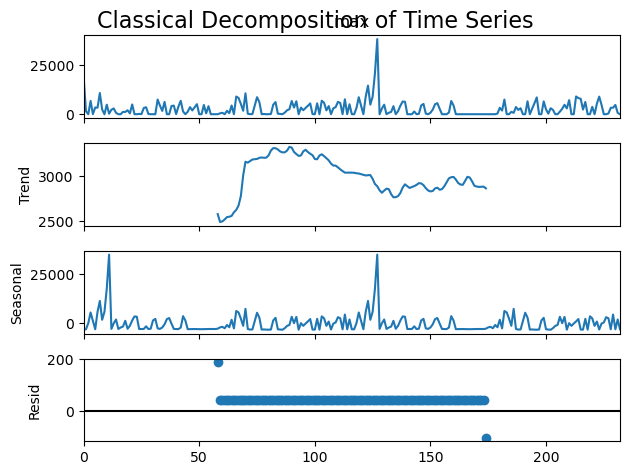

C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


Change detected at index 179
Change detected at index 99
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 116


<Figure size 1000x800 with 0 Axes>

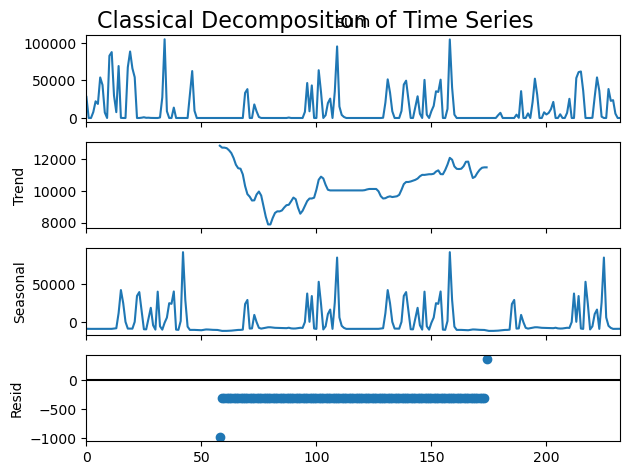

-------------------- Results for avg
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
-------------------- Results for min
Output is stationary? False
Seasonality period is? 4


<Figure size 1000x800 with 0 Axes>

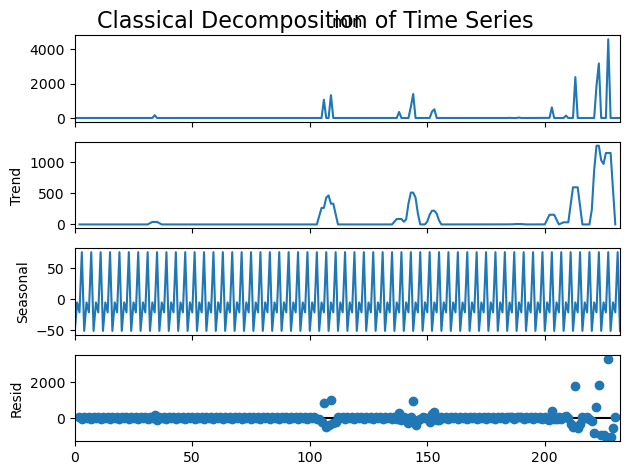

Is stationary after trying to make it stationary? True
-------------------- Results for max
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Change detected at index 169
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
-------------------- Results for avg
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? 7


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

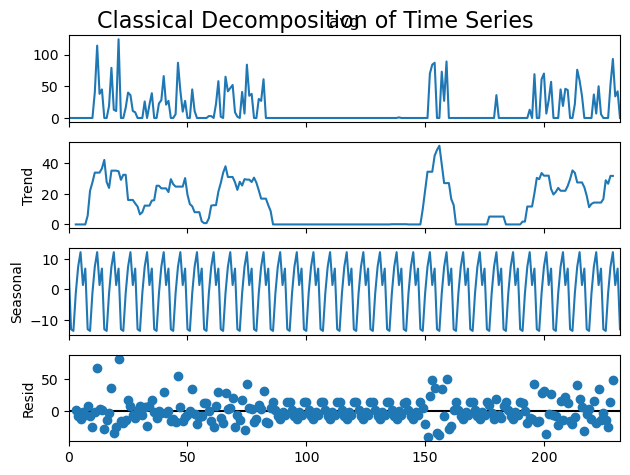

Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? True
Seasonality period is? 2


<Figure size 1000x800 with 0 Axes>

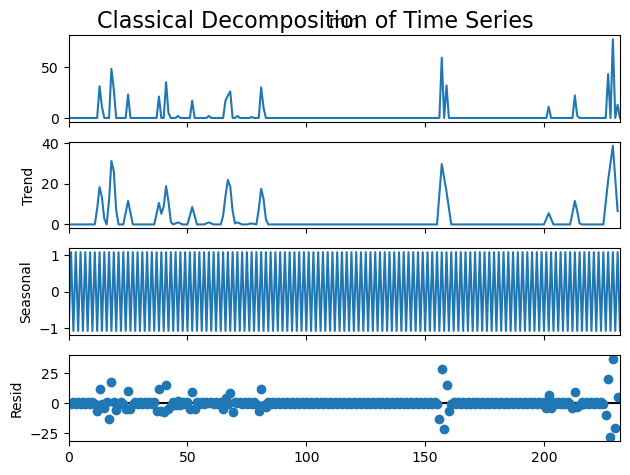

-------------------- Results for max
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
Change detected at index 219
Change detected at index 219
Change detected at index 219
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? False
Seasonality period is? 28


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

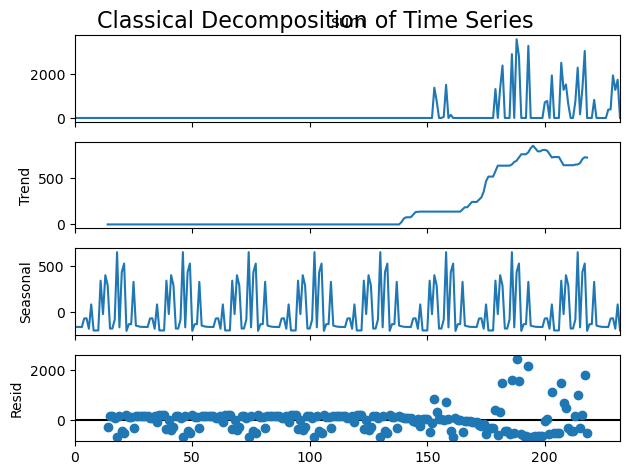

Is stationary after trying to make it stationary? True
-------------------- Results for avg
Output is stationary? False
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

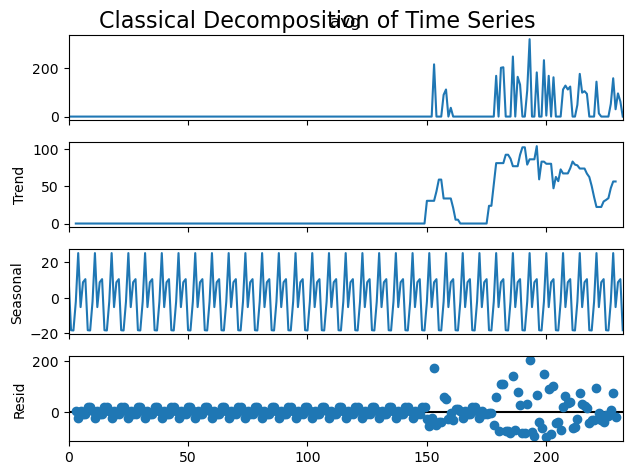

Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? False
Seasonality period is? 19


<Figure size 1000x800 with 0 Axes>

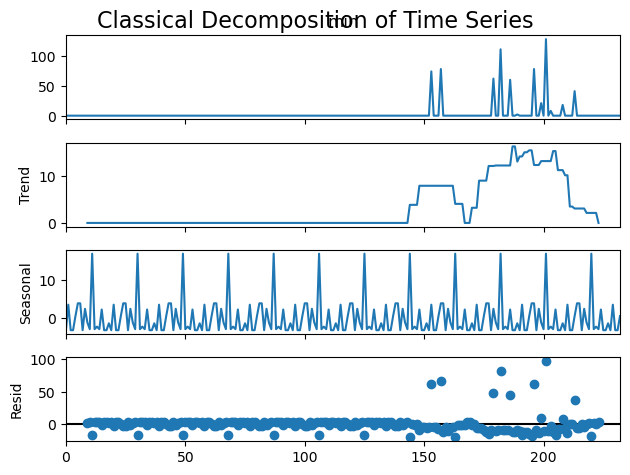

Is stationary after trying to make it stationary? True
-------------------- Results for max
Output is stationary? False
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

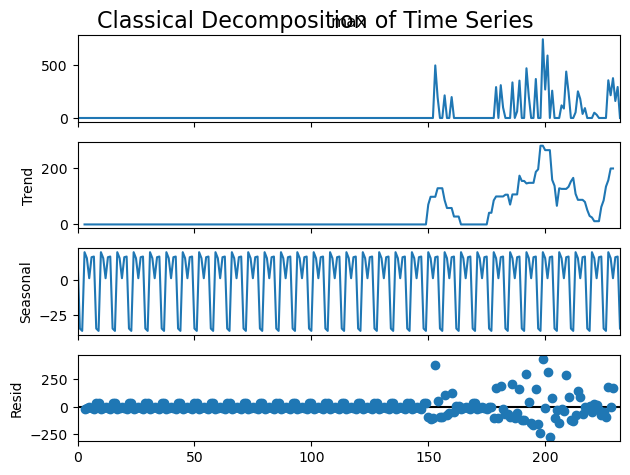

Is stationary after trying to make it stationary? True
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
-------------------- Results for avg
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 2


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

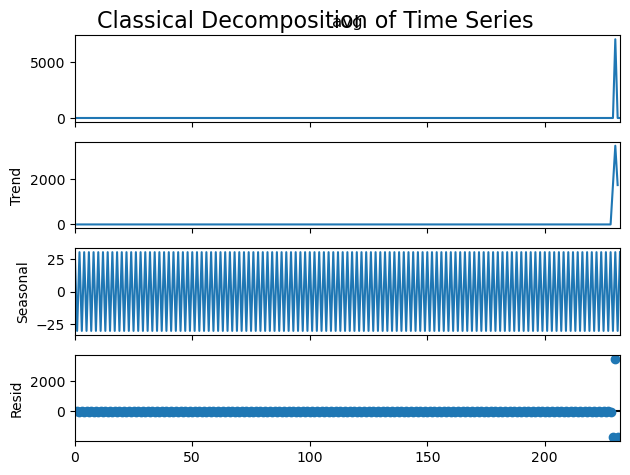

-------------------- Results for min
Output is stationary? None
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? None
-------------------- Results for max
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Change detected at index 149
Change detected at index 149
Change detected at index 139
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? 116


c:\Users\auran\anaconda3\envs\Torch\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

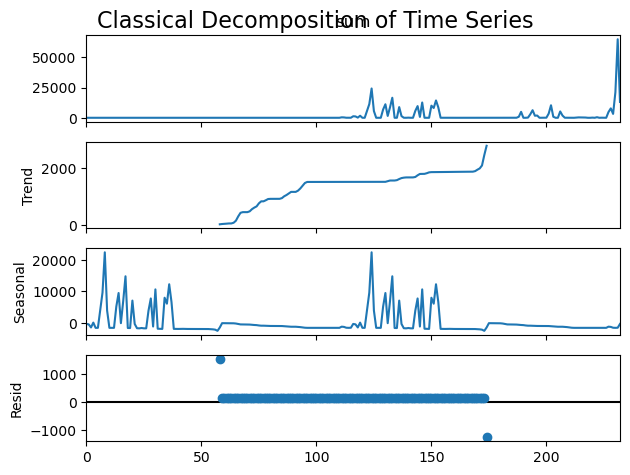

-------------------- Results for avg
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? 26


<Figure size 1000x800 with 0 Axes>

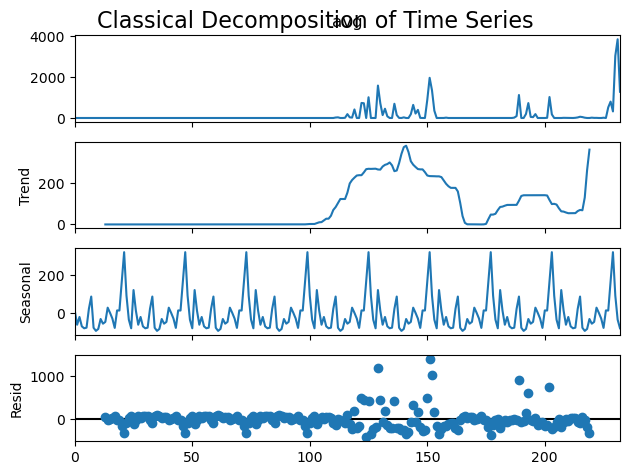

Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? True
Seasonality period is? 42


<Figure size 1000x800 with 0 Axes>

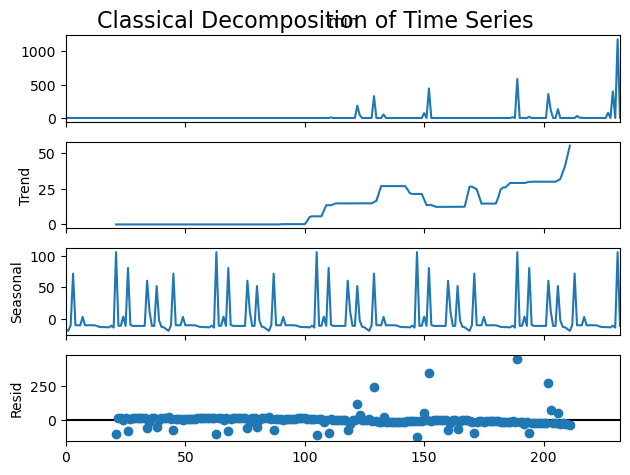

-------------------- Results for max
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
Change detected at index 139
Change detected at index 139
Change detected at index 139
Change detected at index 139
Change detected at index 229
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? False
Seasonality period is? 7


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

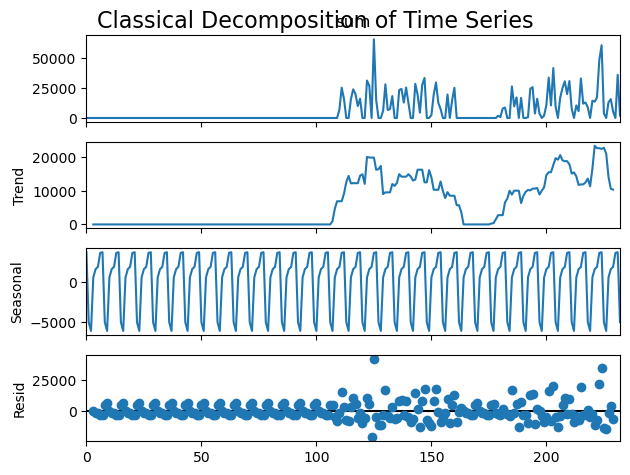

Is stationary after trying to make it stationary? True
-------------------- Results for avg
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? False
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

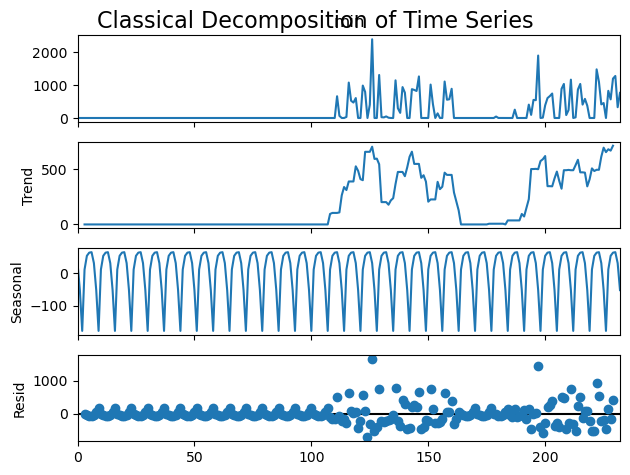

Is stationary after trying to make it stationary? True
-------------------- Results for max
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
Change detected at index 139
Change detected at index 139
Change detected at index 139
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
-------------------- Results for avg
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
--------

C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

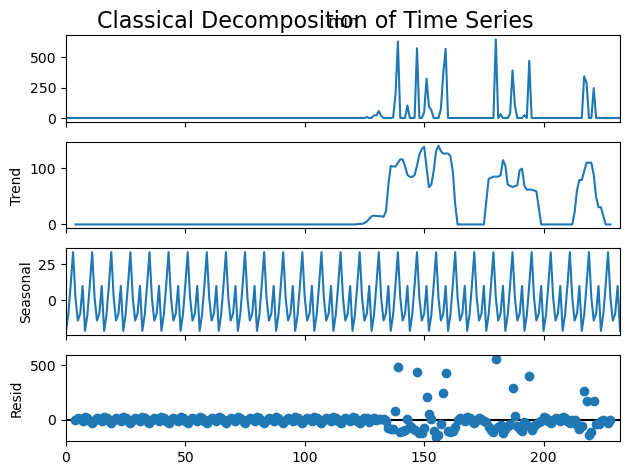

Is stationary after trying to make it stationary? True
-------------------- Results for max
Output is stationary? True
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Change detected at index 139
Change detected at index 139
Change detected at index 149
Change detected at index 139
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? False
Seasonality period is? 7


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

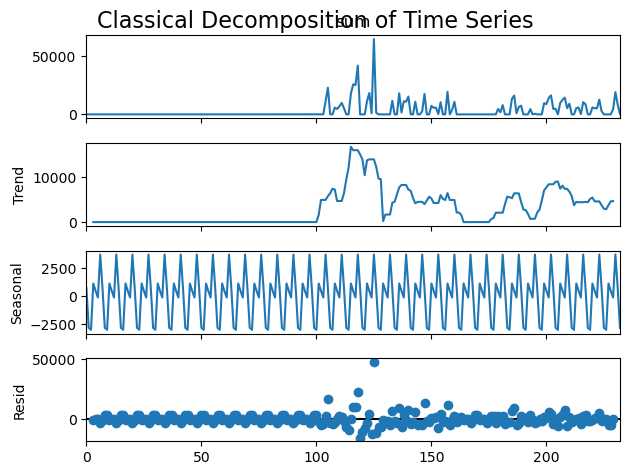

Is stationary after trying to make it stationary? True
-------------------- Results for avg
Output is stationary? False
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

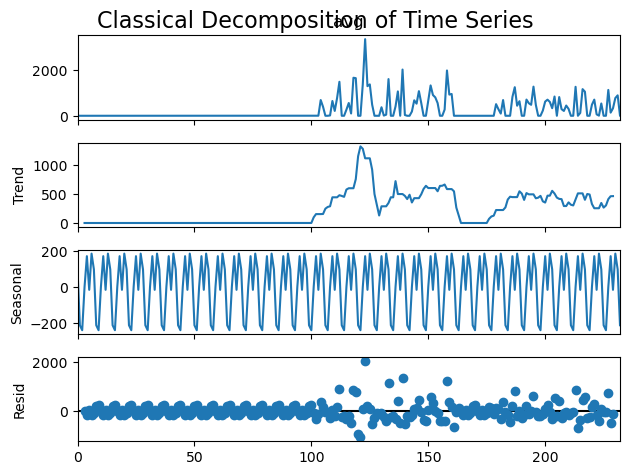

Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? False
Seasonality period is? 34


<Figure size 1000x800 with 0 Axes>

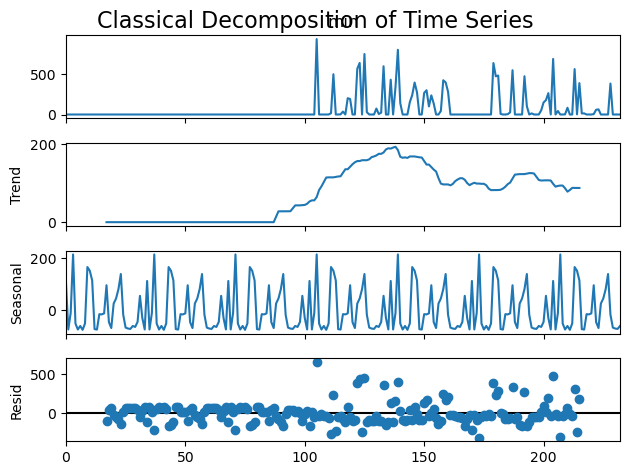

Is stationary after trying to make it stationary? True
-------------------- Results for max
Output is stationary? False
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

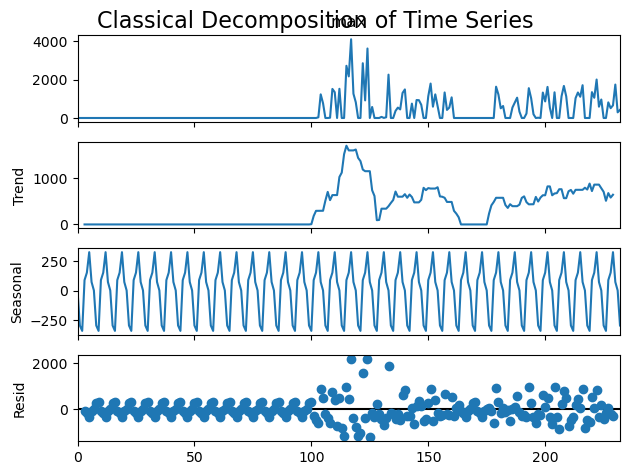

Is stationary after trying to make it stationary? True
Change detected at index 229
Change detected at index 219
Change detected at index 219
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
-------------------- Results for avg
Output is stationary? False
Seasonality period is? 14


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

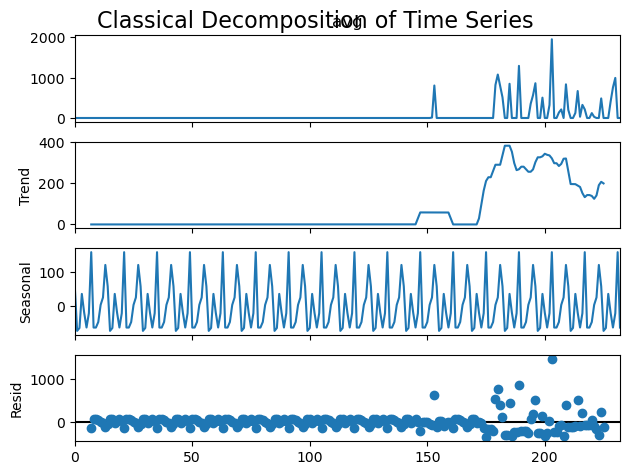

Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? False
Seasonality period is? 10


<Figure size 1000x800 with 0 Axes>

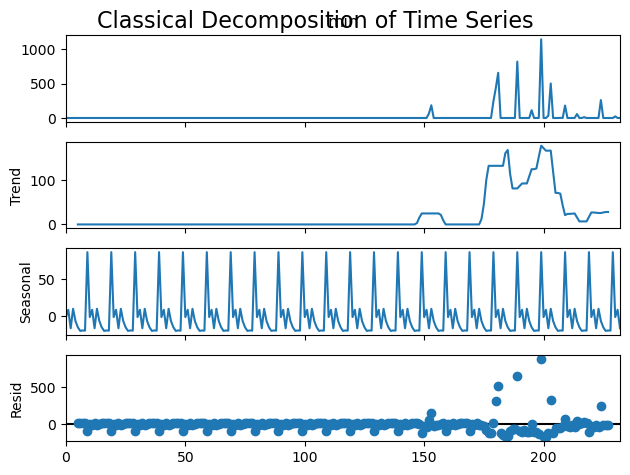

Is stationary after trying to make it stationary? True
-------------------- Results for max
Output is stationary? False
Seasonality period is? 26


<Figure size 1000x800 with 0 Axes>

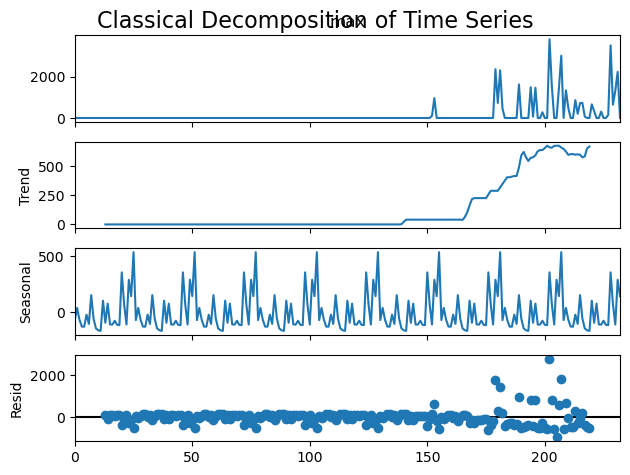

Is stationary after trying to make it stationary? True
Change detected at index 229
Change detected at index 229
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
-------------------- Results for avg
Output is stationary? False
Seasonality period is? 2


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

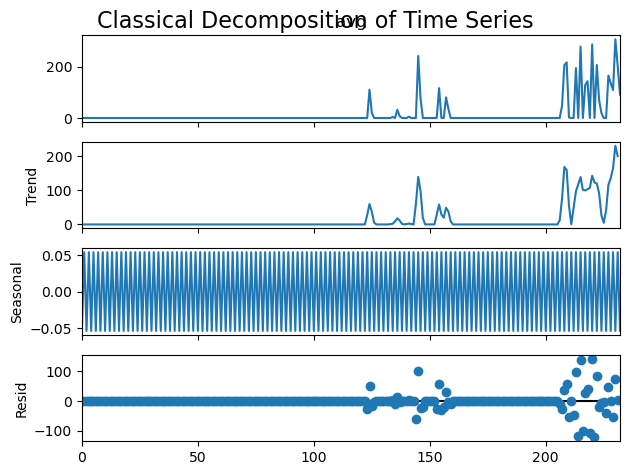

Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? True
Seasonality period is? 105


<Figure size 1000x800 with 0 Axes>

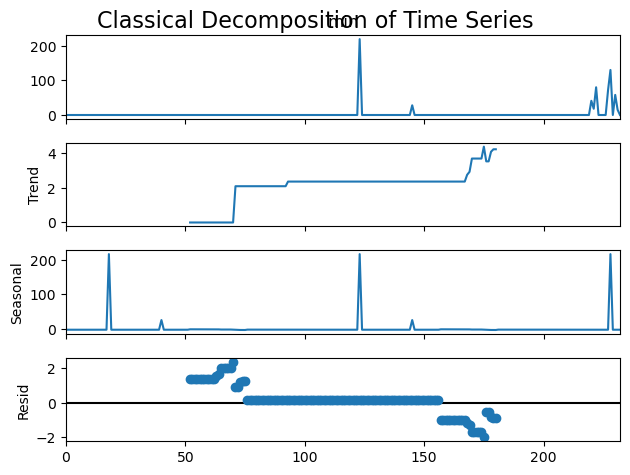

-------------------- Results for max
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? 78


<Figure size 1000x800 with 0 Axes>

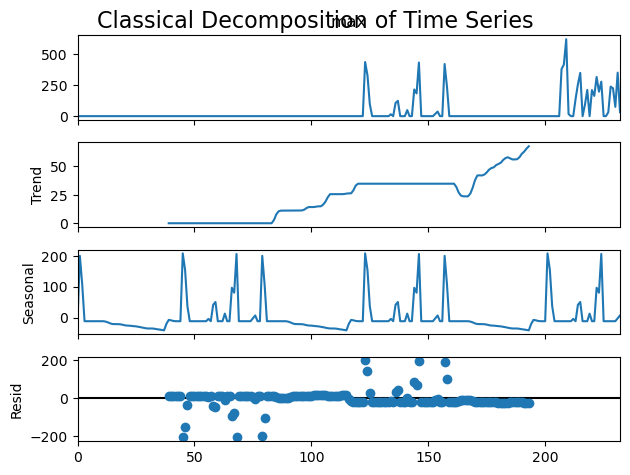

Is stationary after trying to make it stationary? True
Change detected at index 219
Change detected at index 209
Change detected at index 209
_______________________________________
There is drift????? False
_______________________________________
-------------------- Results for sum
Output is stationary? True
Seasonality period is? 35


C:\Users\auran\AppData\Local\Temp\ipykernel_2552\4104776889.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = pd.to_datetime(filtered_data['time'])


<Figure size 1000x800 with 0 Axes>

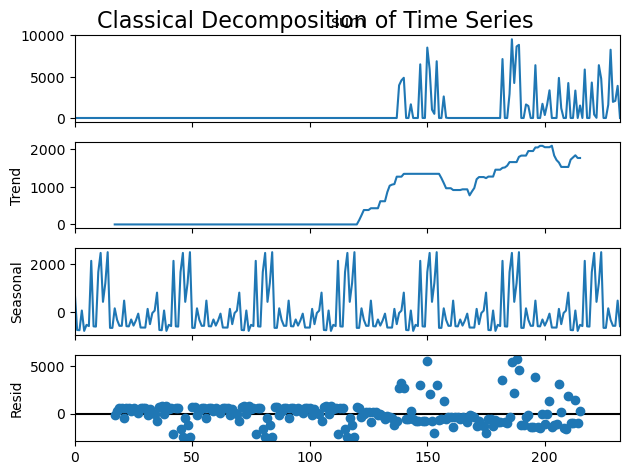

-------------------- Results for avg
Output is stationary? False
Seasonality period is? None
Recomputed seasonality period is? None
Not enough data for two full cycles. Skipping decomposition.
Is stationary after trying to make it stationary? True
-------------------- Results for min
Output is stationary? True
Seasonality period is? 64


<Figure size 1000x800 with 0 Axes>

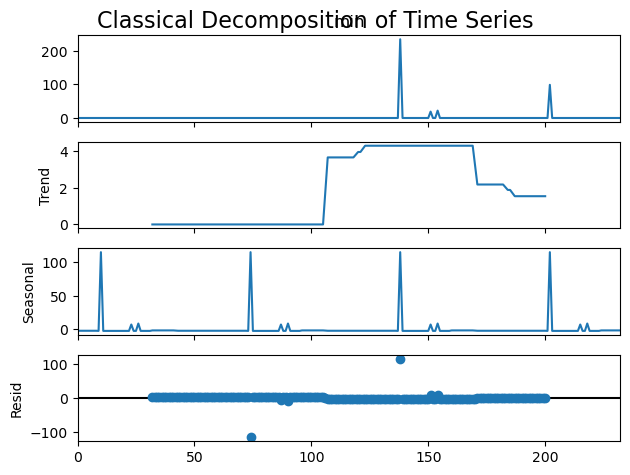

-------------------- Results for max
Output is stationary? False
Seasonality period is? 7


<Figure size 1000x800 with 0 Axes>

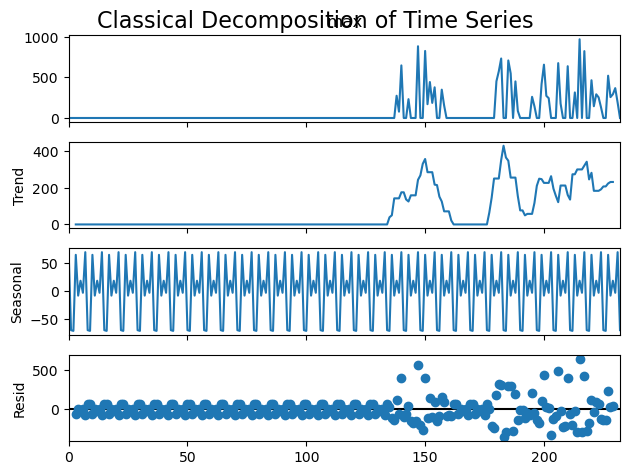

Is stationary after trying to make it stationary? True


In [ ]:
# USAGE
#['working_time' 'idle_time' 'offline_time' 'consumption' 'power'
#'consumption_working' 'consumption_idle' 'cost' 'cost_working'
#'cost_idle' 'cycles' 'good_cycles' 'bad_cycles' 'average_cycle_time']
kpi = 'good_cycles'
machine = 'Large Capacity Cutting Machine 1'
operation = "working"
for machine in machines:
    feature_extracted = extract_features(kpi, machine, operation, historical_data)
    feature_extracted.reset_index(drop=True, inplace=True)

    drift_presence = mlf.ADWIN_drift(feature_extracted)
    transformed_time_series = feature_engineering_pipeline(feature_extracted, processing_config)

